In [1]:
####### load packages ##########
import pandas as pd
import os
import re
import numpy as np
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt

import nltk
from nltk.tokenize import RegexpTokenizer,word_tokenize
from nltk.corpus import stopwords,wordnet
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from autocorrect import spell
from scipy import sparse
import pickle
from sklearn.decomposition import TruncatedSVD
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score,roc_curve, auc,precision_recall_curve,roc_auc_score
from scipy.sparse import hstack
from scipy import interp
from sklearn.model_selection import KFold, RepeatedKFold
from sklearn.preprocessing import LabelEncoder
import lightgbm as lgb
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from collections import Counter
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_auc_score
import time
%matplotlib inline
plt.style.use('ggplot')

In [2]:
cachedStopWords = stopwords.words("english")
stemmer = PorterStemmer().stem
tokenize = nltk.word_tokenize

def stem(tokens,stemmer = PorterStemmer().stem):
     return [stemmer(w.lower()) for w in tokens] 

def lemmatize(text):
     return stem(tokenize(text))

def testFuncNew(text):
    ##### remove stopwords#####
    tokens = word_tokenize(str(text))
    textnew = [w for w in tokens if w not in cachedStopWords]
    return(textnew)

data = pickle.load( open( "final_data.p", "rb" ))
important = pickle.load( open( "new-top-10000.p", "rb" ))
tfs_method1 = pickle.load(open( "new-tfs-10000.p", "rb" ))
tfs_method1_vec = pickle.load(open( "new-tfs-vec-10000.p", "rb" ))

In [3]:
col = set(data.columns)-set(["project_title","project_essay_1","project_essay_2",
                           "project_resource_summary","project_is_approved","text"])
target = 'project_is_approved'

In [4]:
data_new = data[list(col)]
data_arr = data_new.values
data_s=sparse.csr_matrix(data_arr)
data_final = sparse.hstack([data_s,tfs_method1])
y = data[target]
X_train, X_test, y_train, y_test = train_test_split(data_final, y, test_size=0.3, random_state=42)

In [5]:
X_train

<127453x10046 sparse matrix of type '<class 'numpy.float64'>'
	with 17577635 stored elements in Compressed Sparse Row format>

In [6]:
X_test

<54623x10046 sparse matrix of type '<class 'numpy.float64'>'
	with 7534349 stored elements in Compressed Sparse Row format>

<h3> 3.2 Build model with text(Method 1)   

In [7]:
kf = KFold(n_splits=3)
y_train = np.array(y_train)
y_test = np.array(y_test)

In [8]:
y_pred_vali = []
y_pred = []
def fitkfold(model):
    i = 0
    pred = []
    y_pred = []
    y_prob = []
    auc_c = []
    for train_index, valid_index in kf.split(X_train):
        model.fit(X_train[train_index], y_train[train_index])
        pred = model.predict(X_train[valid_index])
        prob = model.predict_proba(X_train[valid_index])[:,1]
        aucc = roc_auc_score(y_train[valid_index], prob)
        i = i + 1
        print('{} AUC: {}'.format(i, aucc))
        
        y_prob = model.predict_proba(X_test)[:,1]
        y_pred = model.predict(X_test)
        if len(y_prob) == 0:
            y_prob = np.array(y_prob)
            y_pred = np.array(y_pred)
        else:
            y_prob += np.array(y_prob)
            y_pred += np.array(y_pred)
        auc_c.append(aucc)
    return(y_prob,y_pred,sum(auc_c)/3)

In [9]:
# Compute ROC curve and ROC area for each class
def plotROC(test, pred):
    fpr, tpr, _ = roc_curve(test, pred)
    roc1auc = auc(fpr, tpr)

    # Plot all ROC curves
    plt.figure()
    plt.plot(fpr, tpr,label='ROC curve of class  (AUC = {0:0.2f})'
                 ''.format(roc1auc))
    
    plt.plot([0, 1], [0, 1])
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC')
    plt.legend(loc="lower right")
    plt.show()

In [10]:
def fitwithoutkfold(model):
    start_time = time.time() 
    model.fit(X_train, y_train)
    pred = model.predict(X_test)
    prob = model.predict_proba(X_test)[:,1]
    aucc = roc_auc_score(y_test, prob)
    acc = accuracy_score(y_test,pred)
    t = time.time()-start_time
    print ("Accuracy %f ,AUC %f,time %lf secs\n"%(acc,aucc,t))

<h3> 3.2.1 Logistic regression </h3>   
First, we want to tuning parameter:   
* solver for l2: "lbfgs","sag","newton-cg"
* solver for l1: "saga"

In [24]:
logit = LogisticRegression(solver = "lbfgs")
fitwithoutkfold(logit)

Accuracy 0.848800 ,AUC 0.732198,time 12.106343 secs



In [25]:
logit = LogisticRegression(solver = "sag",max_iter=300)
fitwithoutkfold(logit)

Accuracy 0.848580 ,AUC 0.742786,time 178.331746 secs



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


In [27]:
logit = LogisticRegression(solver = "sag",max_iter=1000)
fitwithoutkfold(logit)

Accuracy 0.850136 ,AUC 0.754075,time 383.400624 secs



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


In [28]:
logit = LogisticRegression(solver = "newton-cg",max_iter=1000)
fitwithoutkfold(logit)

C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\linesearch.py:285: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\optimize.py:195: UserWarning: Line Search failed
  warnings.warn('Line Search failed')


Accuracy 0.835344 ,AUC 0.700362,time 3189.413866 secs



In [29]:
logit = LogisticRegression(solver = "saga",penalty="l1",max_iter = 1000)
fitwithoutkfold(logit)

Accuracy 0.849294 ,AUC 0.749136,time 5606.904852 secs



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


We can find that with solver = "lbfgs", the model converges very fast. Since the accuracy of other solver is not significantly better, we prefer use this model.   
Then we use 3-fold to fit the model.

In [22]:
start_time = time.time() 
logit = LogisticRegression(solver = "lbfgs")
prob,pred,_ = fitkfold(logit)
t = time.time()-start_time

1 AUC: 0.7310990407225405
2 AUC: 0.7284948932312934
3 AUC: 0.7295709747848439


In [23]:
prob = prob/3
temp = prob.copy()
temp[temp>0.27] = 1
temp[temp<=0.27] = 0

In [24]:
acc = accuracy_score(y_test,temp)
aucv = roc_auc_score(y_test,prob)
print ("Accuracy %f ,AUC %f,time %lf secs\n"%(acc,aucv,t))

Accuracy 0.848470 ,AUC 0.733144,time 16.142558 secs



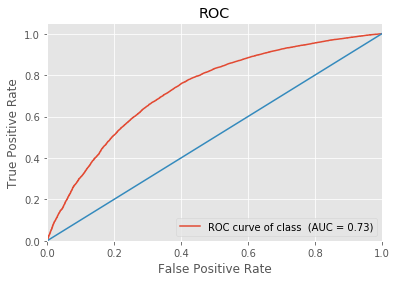

In [25]:
plotROC(y_test,prob)

<h3> 3.2.2 Random Forest </h3>  
First, we want to tuning parameter:   
* n_estimators: 
* max_depth:   
* criterion:

In [11]:
tree  = [1,5,10,50,80,100,200,500]
depth = [1,5,10,50,80,100,200,500]
for i in tree:
    for j in depth:
        print (i,j)
        clf = RandomForestClassifier(n_estimators = i,max_depth=j, criterion='gini', random_state=42)
        fitwithoutkfold(clf)

1 1
Accuracy 0.848232 ,AUC 0.523816,time 1.492525 secs

1 5
Accuracy 0.847921 ,AUC 0.547557,time 1.328534 secs

1 10
Accuracy 0.847097 ,AUC 0.574573,time 1.463440 secs

1 50
Accuracy 0.800542 ,AUC 0.566804,time 9.444160 secs

1 80
Accuracy 0.777621 ,AUC 0.526219,time 14.578139 secs

1 100
Accuracy 0.772788 ,AUC 0.528625,time 14.672997 secs

1 200
Accuracy 0.768358 ,AUC 0.529528,time 16.420575 secs

1 500
Accuracy 0.768358 ,AUC 0.529528,time 16.182118 secs

5 1
Accuracy 0.848232 ,AUC 0.551697,time 1.697862 secs

5 5
Accuracy 0.848232 ,AUC 0.637712,time 2.293639 secs

5 10
Accuracy 0.848232 ,AUC 0.647224,time 3.427344 secs

5 50
Accuracy 0.843363 ,AUC 0.630875,time 40.339094 secs

5 80
Accuracy 0.838914 ,AUC 0.593081,time 67.607493 secs

5 100
Accuracy 0.837193 ,AUC 0.587294,time 73.534677 secs

5 200
Accuracy 0.835289 ,AUC 0.593119,time 78.469631 secs

5 500
Accuracy 0.835729 ,AUC 0.594461,time 78.244358 secs

10 1
Accuracy 0.848232 ,AUC 0.665694,time 2.138188 secs

10 5
Accuracy 0.8482

In [11]:
start_time = time.time() 
clf = RandomForestClassifier(criterion = "entropy",n_estimators = 200,max_depth=10, random_state=42)
prob,pred,_ = fitkfold(clf)
t = time.time()-start_time

1 AUC: 0.7299350017680695
2 AUC: 0.7297978892969342
3 AUC: 0.7296362803350434


In [12]:
prob = prob/3

In [17]:
temp = prob.copy()
temp[temp>0.45] = 1
temp[temp<=0.45] = 0

In [18]:
acc = accuracy_score(y_test,temp)
aucv = roc_auc_score(y_test,prob)
print ("Accuracy %f ,AUC %f,time %lf secs\n"%(acc,aucv,t))

Accuracy 0.848232 ,AUC 0.731030,time 113.146390 secs



In [19]:
start_time = time.time() 
clf = RandomForestClassifier(criterion = "gini",n_estimators = 200,max_depth=10, random_state=42)
prob,pred,_ = fitkfold(clf)
t = time.time()-start_time

1 AUC: 0.7243045661733497
2 AUC: 0.7256490043038113
3 AUC: 0.7248719879671448


In [20]:
prob = prob/3
temp = prob.copy()
temp[temp>0.45] = 1
temp[temp<=0.45] = 0

In [21]:
acc = accuracy_score(y_test,temp)
aucv = roc_auc_score(y_test,prob/3)
print ("Accuracy %f ,AUC %f,time %lf secs\n"%(acc,aucv,t))

Accuracy 0.848232 ,AUC 0.727828,time 125.827721 secs



<h3> 3.2.3 light LGM </h3>  
First, we want to tuning parameter:   
* num_leaves: 
* learning_rate:   
* feature_fraction:
* bagging_fraction:
* num_boost_round:

In [28]:
lgb_train = lgb.Dataset(X_train, y_train)
lgb_eval = lgb.Dataset(X_test, y_test, reference=lgb_train)
num_leaves = [10,30,50,80,100]
learning_rate = [0.01,0.05,0.1,0.5]
feature_fraction = [0.5,0.8,0.9]
for i in num_leaves:
    for j in learning_rate:
        for k in feature_fraction:
                print(i,j,k)
                params = {
                    'task': 'train',
                    'boosting_type': 'gbdt',
                    'objective': 'binary',
                    'metric': {'l2', 'auc'},
                    'num_leaves': i,
                    'learning_rate': j,
                    'feature_fraction': k,
                    'bagging_fraction': 0.8,
                    'bagging_freq': 5,
                    'verbose': 0
                }
                gbm = lgb.train(params,
                    lgb_train,
                    num_boost_round=300,
                    valid_sets=lgb_eval,
                    early_stopping_rounds=5)
                y_pred = gbm.predict(X_test, num_iteration=gbm.best_iteration)


10 0.01 0.5
[1]	valid_0's auc: 0.676368	valid_0's l2: 0.247434
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's auc: 0.702308	valid_0's l2: 0.244892
[3]	valid_0's auc: 0.703187	valid_0's l2: 0.242405
[4]	valid_0's auc: 0.70611	valid_0's l2: 0.240061
[5]	valid_0's auc: 0.705731	valid_0's l2: 0.237697
[6]	valid_0's auc: 0.713044	valid_0's l2: 0.235436
[7]	valid_0's auc: 0.713393	valid_0's l2: 0.233166
[8]	valid_0's auc: 0.713159	valid_0's l2: 0.230917
[9]	valid_0's auc: 0.712953	valid_0's l2: 0.228738
[10]	valid_0's auc: 0.712565	valid_0's l2: 0.226587
[11]	valid_0's auc: 0.712808	valid_0's l2: 0.224513
[12]	valid_0's auc: 0.712304	valid_0's l2: 0.222453
Early stopping, best iteration is:
[7]	valid_0's auc: 0.713393	valid_0's l2: 0.233166
10 0.01 0.8
[1]	valid_0's auc: 0.69097	valid_0's l2: 0.2474
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's auc: 0.696089	valid_0's l2: 0.244839
[3]	valid_0's auc: 0.698004	valid_0's l2: 0.242353
[4]	

[46]	valid_0's auc: 0.723562	valid_0's l2: 0.11774
[47]	valid_0's auc: 0.723894	valid_0's l2: 0.117536
[48]	valid_0's auc: 0.724414	valid_0's l2: 0.117356
[49]	valid_0's auc: 0.72473	valid_0's l2: 0.117188
[50]	valid_0's auc: 0.725272	valid_0's l2: 0.117065
[51]	valid_0's auc: 0.725638	valid_0's l2: 0.116942
[52]	valid_0's auc: 0.726137	valid_0's l2: 0.116813
[53]	valid_0's auc: 0.726548	valid_0's l2: 0.116691
[54]	valid_0's auc: 0.727084	valid_0's l2: 0.116568
[55]	valid_0's auc: 0.727239	valid_0's l2: 0.116445
[56]	valid_0's auc: 0.727551	valid_0's l2: 0.116321
[57]	valid_0's auc: 0.727913	valid_0's l2: 0.11622
[58]	valid_0's auc: 0.728843	valid_0's l2: 0.116124
[59]	valid_0's auc: 0.72902	valid_0's l2: 0.116035
[60]	valid_0's auc: 0.729904	valid_0's l2: 0.115936
[61]	valid_0's auc: 0.730567	valid_0's l2: 0.115849
[62]	valid_0's auc: 0.731004	valid_0's l2: 0.115783
[63]	valid_0's auc: 0.73138	valid_0's l2: 0.115704
[64]	valid_0's auc: 0.731829	valid_0's l2: 0.115631
[65]	valid_0's au

[203]	valid_0's auc: 0.75635	valid_0's l2: 0.111893
[204]	valid_0's auc: 0.756384	valid_0's l2: 0.111884
[205]	valid_0's auc: 0.756454	valid_0's l2: 0.111877
[206]	valid_0's auc: 0.756543	valid_0's l2: 0.111862
[207]	valid_0's auc: 0.756649	valid_0's l2: 0.111846
[208]	valid_0's auc: 0.756738	valid_0's l2: 0.111831
[209]	valid_0's auc: 0.756822	valid_0's l2: 0.111814
[210]	valid_0's auc: 0.756874	valid_0's l2: 0.111806
[211]	valid_0's auc: 0.756968	valid_0's l2: 0.1118
[212]	valid_0's auc: 0.757009	valid_0's l2: 0.111795
[213]	valid_0's auc: 0.757154	valid_0's l2: 0.111777
[214]	valid_0's auc: 0.757238	valid_0's l2: 0.111769
[215]	valid_0's auc: 0.757292	valid_0's l2: 0.111755
[216]	valid_0's auc: 0.757351	valid_0's l2: 0.111743
[217]	valid_0's auc: 0.757451	valid_0's l2: 0.111728
[218]	valid_0's auc: 0.757545	valid_0's l2: 0.111716
[219]	valid_0's auc: 0.757597	valid_0's l2: 0.111711
[220]	valid_0's auc: 0.757644	valid_0's l2: 0.111703
[221]	valid_0's auc: 0.757695	valid_0's l2: 0.111

[57]	valid_0's auc: 0.728803	valid_0's l2: 0.116186
[58]	valid_0's auc: 0.728974	valid_0's l2: 0.116097
[59]	valid_0's auc: 0.729353	valid_0's l2: 0.115998
[60]	valid_0's auc: 0.729505	valid_0's l2: 0.115905
[61]	valid_0's auc: 0.730485	valid_0's l2: 0.115815
[62]	valid_0's auc: 0.731041	valid_0's l2: 0.115734
[63]	valid_0's auc: 0.731252	valid_0's l2: 0.115674
[64]	valid_0's auc: 0.731657	valid_0's l2: 0.115604
[65]	valid_0's auc: 0.732104	valid_0's l2: 0.115536
[66]	valid_0's auc: 0.73243	valid_0's l2: 0.115481
[67]	valid_0's auc: 0.732833	valid_0's l2: 0.11542
[68]	valid_0's auc: 0.733373	valid_0's l2: 0.11534
[69]	valid_0's auc: 0.733825	valid_0's l2: 0.115281
[70]	valid_0's auc: 0.734315	valid_0's l2: 0.115202
[71]	valid_0's auc: 0.7345	valid_0's l2: 0.115157
[72]	valid_0's auc: 0.734645	valid_0's l2: 0.115102
[73]	valid_0's auc: 0.7351	valid_0's l2: 0.115043
[74]	valid_0's auc: 0.735485	valid_0's l2: 0.11499
[75]	valid_0's auc: 0.735643	valid_0's l2: 0.114955
[76]	valid_0's auc: 

[214]	valid_0's auc: 0.757367	valid_0's l2: 0.111764
[215]	valid_0's auc: 0.7574	valid_0's l2: 0.111756
[216]	valid_0's auc: 0.757509	valid_0's l2: 0.111742
[217]	valid_0's auc: 0.757567	valid_0's l2: 0.111733
[218]	valid_0's auc: 0.757626	valid_0's l2: 0.111725
[219]	valid_0's auc: 0.757695	valid_0's l2: 0.111718
[220]	valid_0's auc: 0.75778	valid_0's l2: 0.1117
[221]	valid_0's auc: 0.757876	valid_0's l2: 0.111683
[222]	valid_0's auc: 0.757931	valid_0's l2: 0.111669
[223]	valid_0's auc: 0.757961	valid_0's l2: 0.111661
[224]	valid_0's auc: 0.758053	valid_0's l2: 0.111641
[225]	valid_0's auc: 0.758182	valid_0's l2: 0.111619
[226]	valid_0's auc: 0.758255	valid_0's l2: 0.11161
[227]	valid_0's auc: 0.758347	valid_0's l2: 0.111598
[228]	valid_0's auc: 0.758374	valid_0's l2: 0.111593
[229]	valid_0's auc: 0.758454	valid_0's l2: 0.111583
[230]	valid_0's auc: 0.758568	valid_0's l2: 0.111571
[231]	valid_0's auc: 0.758691	valid_0's l2: 0.111555
[232]	valid_0's auc: 0.758762	valid_0's l2: 0.111543

[68]	valid_0's auc: 0.749278	valid_0's l2: 0.113157
[69]	valid_0's auc: 0.749603	valid_0's l2: 0.113128
[70]	valid_0's auc: 0.749898	valid_0's l2: 0.113068
[71]	valid_0's auc: 0.750187	valid_0's l2: 0.113019
[72]	valid_0's auc: 0.750552	valid_0's l2: 0.112967
[73]	valid_0's auc: 0.750861	valid_0's l2: 0.112902
[74]	valid_0's auc: 0.751127	valid_0's l2: 0.112872
[75]	valid_0's auc: 0.751282	valid_0's l2: 0.112834
[76]	valid_0's auc: 0.75169	valid_0's l2: 0.112778
[77]	valid_0's auc: 0.751931	valid_0's l2: 0.112733
[78]	valid_0's auc: 0.752159	valid_0's l2: 0.112703
[79]	valid_0's auc: 0.752265	valid_0's l2: 0.112691
[80]	valid_0's auc: 0.752651	valid_0's l2: 0.112633
[81]	valid_0's auc: 0.752939	valid_0's l2: 0.112593
[82]	valid_0's auc: 0.753138	valid_0's l2: 0.112561
[83]	valid_0's auc: 0.753364	valid_0's l2: 0.112536
[84]	valid_0's auc: 0.753558	valid_0's l2: 0.112507
[85]	valid_0's auc: 0.753811	valid_0's l2: 0.112456
[86]	valid_0's auc: 0.754123	valid_0's l2: 0.112413
[87]	valid_0'

[224]	valid_0's auc: 0.764706	valid_0's l2: 0.110429
[225]	valid_0's auc: 0.76479	valid_0's l2: 0.110415
[226]	valid_0's auc: 0.764824	valid_0's l2: 0.110415
[227]	valid_0's auc: 0.764904	valid_0's l2: 0.110406
[228]	valid_0's auc: 0.76498	valid_0's l2: 0.1104
[229]	valid_0's auc: 0.765013	valid_0's l2: 0.110389
[230]	valid_0's auc: 0.765079	valid_0's l2: 0.110384
[231]	valid_0's auc: 0.765113	valid_0's l2: 0.11038
[232]	valid_0's auc: 0.765163	valid_0's l2: 0.110375
[233]	valid_0's auc: 0.765209	valid_0's l2: 0.110369
[234]	valid_0's auc: 0.765294	valid_0's l2: 0.110358
[235]	valid_0's auc: 0.76531	valid_0's l2: 0.110355
[236]	valid_0's auc: 0.765379	valid_0's l2: 0.110344
[237]	valid_0's auc: 0.765429	valid_0's l2: 0.11034
[238]	valid_0's auc: 0.765506	valid_0's l2: 0.11033
[239]	valid_0's auc: 0.765595	valid_0's l2: 0.110314
[240]	valid_0's auc: 0.765607	valid_0's l2: 0.11031
[241]	valid_0's auc: 0.765661	valid_0's l2: 0.110301
[242]	valid_0's auc: 0.765688	valid_0's l2: 0.110298
[2

[107]	valid_0's auc: 0.757243	valid_0's l2: 0.111782
[108]	valid_0's auc: 0.757331	valid_0's l2: 0.111758
[109]	valid_0's auc: 0.757496	valid_0's l2: 0.111727
[110]	valid_0's auc: 0.757534	valid_0's l2: 0.1117
[111]	valid_0's auc: 0.75759	valid_0's l2: 0.111683
[112]	valid_0's auc: 0.757848	valid_0's l2: 0.111647
[113]	valid_0's auc: 0.757937	valid_0's l2: 0.111613
[114]	valid_0's auc: 0.757989	valid_0's l2: 0.111599
[115]	valid_0's auc: 0.758134	valid_0's l2: 0.111582
[116]	valid_0's auc: 0.758309	valid_0's l2: 0.111546
[117]	valid_0's auc: 0.75845	valid_0's l2: 0.111522
[118]	valid_0's auc: 0.758569	valid_0's l2: 0.111504
[119]	valid_0's auc: 0.758692	valid_0's l2: 0.111481
[120]	valid_0's auc: 0.758903	valid_0's l2: 0.111456
[121]	valid_0's auc: 0.759036	valid_0's l2: 0.111427
[122]	valid_0's auc: 0.759138	valid_0's l2: 0.111412
[123]	valid_0's auc: 0.75919	valid_0's l2: 0.111404
[124]	valid_0's auc: 0.759295	valid_0's l2: 0.111385
[125]	valid_0's auc: 0.759381	valid_0's l2: 0.11136

[57]	valid_0's auc: 0.745764	valid_0's l2: 0.113531
[58]	valid_0's auc: 0.746221	valid_0's l2: 0.113478
[59]	valid_0's auc: 0.746478	valid_0's l2: 0.113428
[60]	valid_0's auc: 0.746941	valid_0's l2: 0.11336
[61]	valid_0's auc: 0.747043	valid_0's l2: 0.113333
[62]	valid_0's auc: 0.747308	valid_0's l2: 0.113298
[63]	valid_0's auc: 0.747393	valid_0's l2: 0.113255
[64]	valid_0's auc: 0.747758	valid_0's l2: 0.113203
[65]	valid_0's auc: 0.748256	valid_0's l2: 0.113147
[66]	valid_0's auc: 0.748618	valid_0's l2: 0.1131
[67]	valid_0's auc: 0.748822	valid_0's l2: 0.113067
[68]	valid_0's auc: 0.749207	valid_0's l2: 0.113018
[69]	valid_0's auc: 0.749476	valid_0's l2: 0.112979
[70]	valid_0's auc: 0.749761	valid_0's l2: 0.112941
[71]	valid_0's auc: 0.750066	valid_0's l2: 0.112888
[72]	valid_0's auc: 0.750378	valid_0's l2: 0.112851
[73]	valid_0's auc: 0.750629	valid_0's l2: 0.112812
[74]	valid_0's auc: 0.750893	valid_0's l2: 0.112764
[75]	valid_0's auc: 0.751224	valid_0's l2: 0.112718
[76]	valid_0's 

[213]	valid_0's auc: 0.763913	valid_0's l2: 0.110474
[214]	valid_0's auc: 0.763972	valid_0's l2: 0.110464
[215]	valid_0's auc: 0.764008	valid_0's l2: 0.110468
[216]	valid_0's auc: 0.764078	valid_0's l2: 0.110458
[217]	valid_0's auc: 0.764155	valid_0's l2: 0.110444
[218]	valid_0's auc: 0.764117	valid_0's l2: 0.110446
[219]	valid_0's auc: 0.764257	valid_0's l2: 0.110425
[220]	valid_0's auc: 0.764245	valid_0's l2: 0.110423
[221]	valid_0's auc: 0.764275	valid_0's l2: 0.110416
[222]	valid_0's auc: 0.76429	valid_0's l2: 0.11041
[223]	valid_0's auc: 0.764305	valid_0's l2: 0.110403
[224]	valid_0's auc: 0.76435	valid_0's l2: 0.110392
[225]	valid_0's auc: 0.76433	valid_0's l2: 0.110395
[226]	valid_0's auc: 0.764368	valid_0's l2: 0.110392
[227]	valid_0's auc: 0.764405	valid_0's l2: 0.110386
[228]	valid_0's auc: 0.76445	valid_0's l2: 0.110385
[229]	valid_0's auc: 0.764541	valid_0's l2: 0.110373
[230]	valid_0's auc: 0.764549	valid_0's l2: 0.11038
[231]	valid_0's auc: 0.764568	valid_0's l2: 0.11038


[16]	valid_0's auc: 0.747413	valid_0's l2: 0.113194
[17]	valid_0's auc: 0.748553	valid_0's l2: 0.113018
[18]	valid_0's auc: 0.748678	valid_0's l2: 0.113025
[19]	valid_0's auc: 0.749527	valid_0's l2: 0.112834
[20]	valid_0's auc: 0.750306	valid_0's l2: 0.112741
[21]	valid_0's auc: 0.75097	valid_0's l2: 0.112647
[22]	valid_0's auc: 0.751914	valid_0's l2: 0.112512
[23]	valid_0's auc: 0.752158	valid_0's l2: 0.112458
[24]	valid_0's auc: 0.752091	valid_0's l2: 0.112557
[25]	valid_0's auc: 0.752358	valid_0's l2: 0.112509
[26]	valid_0's auc: 0.752777	valid_0's l2: 0.11243
[27]	valid_0's auc: 0.752494	valid_0's l2: 0.112488
[28]	valid_0's auc: 0.752575	valid_0's l2: 0.112488
[29]	valid_0's auc: 0.752551	valid_0's l2: 0.112612
[30]	valid_0's auc: 0.75318	valid_0's l2: 0.11251
[31]	valid_0's auc: 0.75366	valid_0's l2: 0.112457
Early stopping, best iteration is:
[26]	valid_0's auc: 0.752777	valid_0's l2: 0.11243
30 0.01 0.5
[1]	valid_0's auc: 0.69129	valid_0's l2: 0.247406
Training until validation

[61]	valid_0's auc: 0.745625	valid_0's l2: 0.113988
[62]	valid_0's auc: 0.746026	valid_0's l2: 0.113922
[63]	valid_0's auc: 0.746259	valid_0's l2: 0.113832
[64]	valid_0's auc: 0.746406	valid_0's l2: 0.113766
[65]	valid_0's auc: 0.746785	valid_0's l2: 0.113666
[66]	valid_0's auc: 0.747173	valid_0's l2: 0.11361
[67]	valid_0's auc: 0.747518	valid_0's l2: 0.11355
[68]	valid_0's auc: 0.747795	valid_0's l2: 0.11349
[69]	valid_0's auc: 0.74819	valid_0's l2: 0.113444
[70]	valid_0's auc: 0.748516	valid_0's l2: 0.113344
[71]	valid_0's auc: 0.74861	valid_0's l2: 0.113297
[72]	valid_0's auc: 0.748864	valid_0's l2: 0.113218
[73]	valid_0's auc: 0.749031	valid_0's l2: 0.113136
[74]	valid_0's auc: 0.749355	valid_0's l2: 0.11306
[75]	valid_0's auc: 0.749497	valid_0's l2: 0.112996
[76]	valid_0's auc: 0.749849	valid_0's l2: 0.112943
[77]	valid_0's auc: 0.750401	valid_0's l2: 0.112854
[78]	valid_0's auc: 0.75054	valid_0's l2: 0.112825
[79]	valid_0's auc: 0.750674	valid_0's l2: 0.112795
[80]	valid_0's auc:

[217]	valid_0's auc: 0.768032	valid_0's l2: 0.109849
[218]	valid_0's auc: 0.768094	valid_0's l2: 0.109839
[219]	valid_0's auc: 0.768115	valid_0's l2: 0.109828
[220]	valid_0's auc: 0.768163	valid_0's l2: 0.10982
[221]	valid_0's auc: 0.768153	valid_0's l2: 0.109819
[222]	valid_0's auc: 0.768175	valid_0's l2: 0.10981
[223]	valid_0's auc: 0.768199	valid_0's l2: 0.109799
[224]	valid_0's auc: 0.768321	valid_0's l2: 0.109784
[225]	valid_0's auc: 0.768373	valid_0's l2: 0.109772
[226]	valid_0's auc: 0.768445	valid_0's l2: 0.109765
[227]	valid_0's auc: 0.768472	valid_0's l2: 0.109759
[228]	valid_0's auc: 0.768516	valid_0's l2: 0.109749
[229]	valid_0's auc: 0.768545	valid_0's l2: 0.109747
[230]	valid_0's auc: 0.768515	valid_0's l2: 0.109749
[231]	valid_0's auc: 0.768585	valid_0's l2: 0.109733
[232]	valid_0's auc: 0.768607	valid_0's l2: 0.109724
[233]	valid_0's auc: 0.768663	valid_0's l2: 0.109717
[234]	valid_0's auc: 0.768687	valid_0's l2: 0.109716
[235]	valid_0's auc: 0.768706	valid_0's l2: 0.10

[71]	valid_0's auc: 0.748203	valid_0's l2: 0.112964
[72]	valid_0's auc: 0.748468	valid_0's l2: 0.112902
[73]	valid_0's auc: 0.748718	valid_0's l2: 0.112834
[74]	valid_0's auc: 0.749116	valid_0's l2: 0.112779
[75]	valid_0's auc: 0.749308	valid_0's l2: 0.112734
[76]	valid_0's auc: 0.749592	valid_0's l2: 0.112695
[77]	valid_0's auc: 0.75016	valid_0's l2: 0.112617
[78]	valid_0's auc: 0.750453	valid_0's l2: 0.112584
[79]	valid_0's auc: 0.750606	valid_0's l2: 0.112557
[80]	valid_0's auc: 0.750975	valid_0's l2: 0.112511
[81]	valid_0's auc: 0.751628	valid_0's l2: 0.11243
[82]	valid_0's auc: 0.752106	valid_0's l2: 0.112355
[83]	valid_0's auc: 0.752332	valid_0's l2: 0.112327
[84]	valid_0's auc: 0.752594	valid_0's l2: 0.112289
[85]	valid_0's auc: 0.752807	valid_0's l2: 0.112264
[86]	valid_0's auc: 0.753065	valid_0's l2: 0.112237
[87]	valid_0's auc: 0.753233	valid_0's l2: 0.112213
[88]	valid_0's auc: 0.753344	valid_0's l2: 0.112183
[89]	valid_0's auc: 0.753561	valid_0's l2: 0.112158
[90]	valid_0's

[227]	valid_0's auc: 0.768128	valid_0's l2: 0.109814
[228]	valid_0's auc: 0.768153	valid_0's l2: 0.10981
[229]	valid_0's auc: 0.768248	valid_0's l2: 0.1098
[230]	valid_0's auc: 0.768274	valid_0's l2: 0.109797
[231]	valid_0's auc: 0.768278	valid_0's l2: 0.109798
[232]	valid_0's auc: 0.768304	valid_0's l2: 0.109787
[233]	valid_0's auc: 0.768388	valid_0's l2: 0.10977
[234]	valid_0's auc: 0.768432	valid_0's l2: 0.109762
[235]	valid_0's auc: 0.768445	valid_0's l2: 0.109753
[236]	valid_0's auc: 0.768484	valid_0's l2: 0.109744
[237]	valid_0's auc: 0.768491	valid_0's l2: 0.109738
[238]	valid_0's auc: 0.768511	valid_0's l2: 0.109737
[239]	valid_0's auc: 0.768548	valid_0's l2: 0.109726
[240]	valid_0's auc: 0.768551	valid_0's l2: 0.109726
[241]	valid_0's auc: 0.76857	valid_0's l2: 0.109715
[242]	valid_0's auc: 0.768635	valid_0's l2: 0.109706
[243]	valid_0's auc: 0.768685	valid_0's l2: 0.109701
[244]	valid_0's auc: 0.768747	valid_0's l2: 0.109694
[245]	valid_0's auc: 0.768777	valid_0's l2: 0.10969

[107]	valid_0's auc: 0.75672	valid_0's l2: 0.111594
[108]	valid_0's auc: 0.756885	valid_0's l2: 0.111564
[109]	valid_0's auc: 0.757104	valid_0's l2: 0.111527
[110]	valid_0's auc: 0.75718	valid_0's l2: 0.111515
[111]	valid_0's auc: 0.757321	valid_0's l2: 0.11148
[112]	valid_0's auc: 0.757617	valid_0's l2: 0.111441
[113]	valid_0's auc: 0.757706	valid_0's l2: 0.111421
[114]	valid_0's auc: 0.757782	valid_0's l2: 0.111405
[115]	valid_0's auc: 0.758011	valid_0's l2: 0.111368
[116]	valid_0's auc: 0.758278	valid_0's l2: 0.111331
[117]	valid_0's auc: 0.758412	valid_0's l2: 0.111309
[118]	valid_0's auc: 0.758595	valid_0's l2: 0.111285
[119]	valid_0's auc: 0.758832	valid_0's l2: 0.111251
[120]	valid_0's auc: 0.758903	valid_0's l2: 0.11124
[121]	valid_0's auc: 0.759067	valid_0's l2: 0.111208
[122]	valid_0's auc: 0.759247	valid_0's l2: 0.111184
[123]	valid_0's auc: 0.759362	valid_0's l2: 0.11116
[124]	valid_0's auc: 0.759429	valid_0's l2: 0.111141
[125]	valid_0's auc: 0.759541	valid_0's l2: 0.11112

[33]	valid_0's auc: 0.74432	valid_0's l2: 0.113696
[34]	valid_0's auc: 0.744779	valid_0's l2: 0.113559
[35]	valid_0's auc: 0.74582	valid_0's l2: 0.113425
[36]	valid_0's auc: 0.746709	valid_0's l2: 0.113238
[37]	valid_0's auc: 0.747378	valid_0's l2: 0.1131
[38]	valid_0's auc: 0.748772	valid_0's l2: 0.112923
[39]	valid_0's auc: 0.749388	valid_0's l2: 0.112843
[40]	valid_0's auc: 0.749978	valid_0's l2: 0.11273
[41]	valid_0's auc: 0.750711	valid_0's l2: 0.112634
[42]	valid_0's auc: 0.751267	valid_0's l2: 0.112544
[43]	valid_0's auc: 0.751765	valid_0's l2: 0.112493
[44]	valid_0's auc: 0.751997	valid_0's l2: 0.112443
[45]	valid_0's auc: 0.75244	valid_0's l2: 0.112381
[46]	valid_0's auc: 0.753278	valid_0's l2: 0.112267
[47]	valid_0's auc: 0.753769	valid_0's l2: 0.112152
[48]	valid_0's auc: 0.754377	valid_0's l2: 0.112069
[49]	valid_0's auc: 0.754717	valid_0's l2: 0.112009
[50]	valid_0's auc: 0.755302	valid_0's l2: 0.111944
[51]	valid_0's auc: 0.755402	valid_0's l2: 0.111914
[52]	valid_0's auc

[6]	valid_0's auc: 0.720187	valid_0's l2: 0.155436
[7]	valid_0's auc: 0.721452	valid_0's l2: 0.148234
[8]	valid_0's auc: 0.723225	valid_0's l2: 0.142304
[9]	valid_0's auc: 0.724107	valid_0's l2: 0.137422
[10]	valid_0's auc: 0.725478	valid_0's l2: 0.133404
[11]	valid_0's auc: 0.726425	valid_0's l2: 0.130111
[12]	valid_0's auc: 0.726828	valid_0's l2: 0.127379
[13]	valid_0's auc: 0.727561	valid_0's l2: 0.125142
[14]	valid_0's auc: 0.728047	valid_0's l2: 0.123269
[15]	valid_0's auc: 0.728574	valid_0's l2: 0.121726
[16]	valid_0's auc: 0.72999	valid_0's l2: 0.120454
[17]	valid_0's auc: 0.731111	valid_0's l2: 0.11941
[18]	valid_0's auc: 0.731781	valid_0's l2: 0.118537
[19]	valid_0's auc: 0.732571	valid_0's l2: 0.117805
[20]	valid_0's auc: 0.733872	valid_0's l2: 0.117078
[21]	valid_0's auc: 0.734378	valid_0's l2: 0.116538
[22]	valid_0's auc: 0.735341	valid_0's l2: 0.116101
[23]	valid_0's auc: 0.736669	valid_0's l2: 0.115651
[24]	valid_0's auc: 0.737344	valid_0's l2: 0.115261
[25]	valid_0's auc

[48]	valid_0's auc: 0.753636	valid_0's l2: 0.111965
[49]	valid_0's auc: 0.753795	valid_0's l2: 0.111938
[50]	valid_0's auc: 0.754249	valid_0's l2: 0.11188
[51]	valid_0's auc: 0.754428	valid_0's l2: 0.111851
[52]	valid_0's auc: 0.754691	valid_0's l2: 0.111827
[53]	valid_0's auc: 0.755083	valid_0's l2: 0.111748
[54]	valid_0's auc: 0.755739	valid_0's l2: 0.111662
[55]	valid_0's auc: 0.75583	valid_0's l2: 0.111654
[56]	valid_0's auc: 0.756602	valid_0's l2: 0.111543
[57]	valid_0's auc: 0.756854	valid_0's l2: 0.111515
[58]	valid_0's auc: 0.757064	valid_0's l2: 0.111478
[59]	valid_0's auc: 0.75751	valid_0's l2: 0.111407
[60]	valid_0's auc: 0.757794	valid_0's l2: 0.111363
[61]	valid_0's auc: 0.758034	valid_0's l2: 0.111324
[62]	valid_0's auc: 0.758399	valid_0's l2: 0.111261
[63]	valid_0's auc: 0.758605	valid_0's l2: 0.111217
[64]	valid_0's auc: 0.758911	valid_0's l2: 0.111157
[65]	valid_0's auc: 0.759221	valid_0's l2: 0.111109
[66]	valid_0's auc: 0.759591	valid_0's l2: 0.111074
[67]	valid_0's 

[1]	valid_0's auc: 0.706282	valid_0's l2: 0.247364
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's auc: 0.714456	valid_0's l2: 0.244767
[3]	valid_0's auc: 0.716275	valid_0's l2: 0.242244
[4]	valid_0's auc: 0.716897	valid_0's l2: 0.239768
[5]	valid_0's auc: 0.719705	valid_0's l2: 0.237352
[6]	valid_0's auc: 0.721147	valid_0's l2: 0.234979
[7]	valid_0's auc: 0.722404	valid_0's l2: 0.232649
[8]	valid_0's auc: 0.72319	valid_0's l2: 0.230359
[9]	valid_0's auc: 0.723168	valid_0's l2: 0.228105
[10]	valid_0's auc: 0.723401	valid_0's l2: 0.225906
[11]	valid_0's auc: 0.723785	valid_0's l2: 0.22375
[12]	valid_0's auc: 0.72392	valid_0's l2: 0.221633
[13]	valid_0's auc: 0.723977	valid_0's l2: 0.219546
[14]	valid_0's auc: 0.723827	valid_0's l2: 0.217505
[15]	valid_0's auc: 0.723673	valid_0's l2: 0.215503
[16]	valid_0's auc: 0.724311	valid_0's l2: 0.21354
[17]	valid_0's auc: 0.724707	valid_0's l2: 0.211633
[18]	valid_0's auc: 0.724769	valid_0's l2: 0.209757
[19]	valid_0's a

[99]	valid_0's auc: 0.758459	valid_0's l2: 0.111462
[100]	valid_0's auc: 0.758707	valid_0's l2: 0.111407
[101]	valid_0's auc: 0.758906	valid_0's l2: 0.111378
[102]	valid_0's auc: 0.759025	valid_0's l2: 0.11135
[103]	valid_0's auc: 0.759213	valid_0's l2: 0.111326
[104]	valid_0's auc: 0.759446	valid_0's l2: 0.111282
[105]	valid_0's auc: 0.759683	valid_0's l2: 0.111238
[106]	valid_0's auc: 0.759991	valid_0's l2: 0.111195
[107]	valid_0's auc: 0.760133	valid_0's l2: 0.111153
[108]	valid_0's auc: 0.760095	valid_0's l2: 0.111139
[109]	valid_0's auc: 0.760303	valid_0's l2: 0.111101
[110]	valid_0's auc: 0.760455	valid_0's l2: 0.111076
[111]	valid_0's auc: 0.760765	valid_0's l2: 0.111037
[112]	valid_0's auc: 0.761001	valid_0's l2: 0.111004
[113]	valid_0's auc: 0.761087	valid_0's l2: 0.110982
[114]	valid_0's auc: 0.761172	valid_0's l2: 0.110967
[115]	valid_0's auc: 0.761292	valid_0's l2: 0.110943
[116]	valid_0's auc: 0.761423	valid_0's l2: 0.110914
[117]	valid_0's auc: 0.76154	valid_0's l2: 0.110

[255]	valid_0's auc: 0.770875	valid_0's l2: 0.10927
[256]	valid_0's auc: 0.770911	valid_0's l2: 0.109266
[257]	valid_0's auc: 0.770941	valid_0's l2: 0.10926
[258]	valid_0's auc: 0.770959	valid_0's l2: 0.109258
[259]	valid_0's auc: 0.771062	valid_0's l2: 0.109245
[260]	valid_0's auc: 0.771015	valid_0's l2: 0.109251
[261]	valid_0's auc: 0.771013	valid_0's l2: 0.109247
[262]	valid_0's auc: 0.770997	valid_0's l2: 0.109251
[263]	valid_0's auc: 0.771003	valid_0's l2: 0.10925
[264]	valid_0's auc: 0.77101	valid_0's l2: 0.109249
Early stopping, best iteration is:
[259]	valid_0's auc: 0.771062	valid_0's l2: 0.109245
50 0.05 0.8
[1]	valid_0's auc: 0.706282	valid_0's l2: 0.237092
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's auc: 0.713912	valid_0's l2: 0.225386
[3]	valid_0's auc: 0.716212	valid_0's l2: 0.214911
[4]	valid_0's auc: 0.717818	valid_0's l2: 0.205446
[5]	valid_0's auc: 0.72091	valid_0's l2: 0.196918
[6]	valid_0's auc: 0.722244	valid_0's l2: 0.189199
[7]	vali

[146]	valid_0's auc: 0.76586	valid_0's l2: 0.109961
[147]	valid_0's auc: 0.765992	valid_0's l2: 0.10994
[148]	valid_0's auc: 0.765966	valid_0's l2: 0.109942
[149]	valid_0's auc: 0.765982	valid_0's l2: 0.109934
[150]	valid_0's auc: 0.766067	valid_0's l2: 0.109916
[151]	valid_0's auc: 0.766052	valid_0's l2: 0.109906
[152]	valid_0's auc: 0.766199	valid_0's l2: 0.10989
[153]	valid_0's auc: 0.766363	valid_0's l2: 0.10988
[154]	valid_0's auc: 0.766336	valid_0's l2: 0.109878
[155]	valid_0's auc: 0.766351	valid_0's l2: 0.109876
[156]	valid_0's auc: 0.766422	valid_0's l2: 0.10987
[157]	valid_0's auc: 0.766452	valid_0's l2: 0.109861
[158]	valid_0's auc: 0.766601	valid_0's l2: 0.109845
[159]	valid_0's auc: 0.766752	valid_0's l2: 0.109821
[160]	valid_0's auc: 0.76693	valid_0's l2: 0.109799
[161]	valid_0's auc: 0.767049	valid_0's l2: 0.109786
[162]	valid_0's auc: 0.767059	valid_0's l2: 0.109783
[163]	valid_0's auc: 0.767128	valid_0's l2: 0.10977
[164]	valid_0's auc: 0.76723	valid_0's l2: 0.109753
[

[45]	valid_0's auc: 0.740466	valid_0's l2: 0.115269
[46]	valid_0's auc: 0.741007	valid_0's l2: 0.115033
[47]	valid_0's auc: 0.741456	valid_0's l2: 0.114813
[48]	valid_0's auc: 0.741676	valid_0's l2: 0.114642
[49]	valid_0's auc: 0.742136	valid_0's l2: 0.114444
[50]	valid_0's auc: 0.742508	valid_0's l2: 0.11429
[51]	valid_0's auc: 0.74317	valid_0's l2: 0.114109
[52]	valid_0's auc: 0.743728	valid_0's l2: 0.11396
[53]	valid_0's auc: 0.744206	valid_0's l2: 0.113825
[54]	valid_0's auc: 0.744364	valid_0's l2: 0.113722
[55]	valid_0's auc: 0.744636	valid_0's l2: 0.113623
[56]	valid_0's auc: 0.745103	valid_0's l2: 0.113499
[57]	valid_0's auc: 0.745586	valid_0's l2: 0.113387
[58]	valid_0's auc: 0.746102	valid_0's l2: 0.113272
[59]	valid_0's auc: 0.746522	valid_0's l2: 0.113175
[60]	valid_0's auc: 0.747078	valid_0's l2: 0.113049
[61]	valid_0's auc: 0.74736	valid_0's l2: 0.112964
[62]	valid_0's auc: 0.747685	valid_0's l2: 0.112871
[63]	valid_0's auc: 0.747895	valid_0's l2: 0.112805
[64]	valid_0's a

[202]	valid_0's auc: 0.768677	valid_0's l2: 0.109504
[203]	valid_0's auc: 0.768716	valid_0's l2: 0.109498
[204]	valid_0's auc: 0.768772	valid_0's l2: 0.109485
[205]	valid_0's auc: 0.768761	valid_0's l2: 0.109484
[206]	valid_0's auc: 0.768803	valid_0's l2: 0.109475
[207]	valid_0's auc: 0.768812	valid_0's l2: 0.109464
[208]	valid_0's auc: 0.768864	valid_0's l2: 0.109462
[209]	valid_0's auc: 0.768891	valid_0's l2: 0.109455
[210]	valid_0's auc: 0.76892	valid_0's l2: 0.109448
[211]	valid_0's auc: 0.768975	valid_0's l2: 0.109439
[212]	valid_0's auc: 0.769076	valid_0's l2: 0.109435
[213]	valid_0's auc: 0.769137	valid_0's l2: 0.109434
[214]	valid_0's auc: 0.769187	valid_0's l2: 0.10943
[215]	valid_0's auc: 0.769256	valid_0's l2: 0.109426
[216]	valid_0's auc: 0.769236	valid_0's l2: 0.109428
[217]	valid_0's auc: 0.769278	valid_0's l2: 0.109417
[218]	valid_0's auc: 0.769275	valid_0's l2: 0.109412
[219]	valid_0's auc: 0.7693	valid_0's l2: 0.109406
[220]	valid_0's auc: 0.76936	valid_0's l2: 0.10940

[97]	valid_0's auc: 0.765849	valid_0's l2: 0.110035
[98]	valid_0's auc: 0.76567	valid_0's l2: 0.110044
[99]	valid_0's auc: 0.765691	valid_0's l2: 0.110032
[100]	valid_0's auc: 0.765784	valid_0's l2: 0.110015
[101]	valid_0's auc: 0.765975	valid_0's l2: 0.109976
[102]	valid_0's auc: 0.766161	valid_0's l2: 0.10994
[103]	valid_0's auc: 0.766121	valid_0's l2: 0.109943
[104]	valid_0's auc: 0.766214	valid_0's l2: 0.10994
[105]	valid_0's auc: 0.766326	valid_0's l2: 0.109924
[106]	valid_0's auc: 0.766402	valid_0's l2: 0.109907
[107]	valid_0's auc: 0.766515	valid_0's l2: 0.10989
[108]	valid_0's auc: 0.766467	valid_0's l2: 0.109886
[109]	valid_0's auc: 0.766481	valid_0's l2: 0.109889
[110]	valid_0's auc: 0.766479	valid_0's l2: 0.109886
[111]	valid_0's auc: 0.766584	valid_0's l2: 0.109867
[112]	valid_0's auc: 0.76659	valid_0's l2: 0.109871
[113]	valid_0's auc: 0.766715	valid_0's l2: 0.109858
[114]	valid_0's auc: 0.766853	valid_0's l2: 0.109838
[115]	valid_0's auc: 0.766899	valid_0's l2: 0.10982
[1

[12]	valid_0's auc: 0.730037	valid_0's l2: 0.126727
[13]	valid_0's auc: 0.730455	valid_0's l2: 0.124498
[14]	valid_0's auc: 0.731462	valid_0's l2: 0.122586
[15]	valid_0's auc: 0.732061	valid_0's l2: 0.121062
[16]	valid_0's auc: 0.732908	valid_0's l2: 0.119821
[17]	valid_0's auc: 0.734412	valid_0's l2: 0.118683
[18]	valid_0's auc: 0.734981	valid_0's l2: 0.117856
[19]	valid_0's auc: 0.736699	valid_0's l2: 0.11704
[20]	valid_0's auc: 0.737725	valid_0's l2: 0.116362
[21]	valid_0's auc: 0.738871	valid_0's l2: 0.115747
[22]	valid_0's auc: 0.739686	valid_0's l2: 0.11531
[23]	valid_0's auc: 0.740493	valid_0's l2: 0.114842
[24]	valid_0's auc: 0.741096	valid_0's l2: 0.114511
[25]	valid_0's auc: 0.74218	valid_0's l2: 0.114195
[26]	valid_0's auc: 0.743264	valid_0's l2: 0.113907
[27]	valid_0's auc: 0.744071	valid_0's l2: 0.113657
[28]	valid_0's auc: 0.744997	valid_0's l2: 0.113419
[29]	valid_0's auc: 0.745758	valid_0's l2: 0.113217
[30]	valid_0's auc: 0.746859	valid_0's l2: 0.112987
[31]	valid_0's 

[13]	valid_0's auc: 0.731717	valid_0's l2: 0.219885
[14]	valid_0's auc: 0.732225	valid_0's l2: 0.217829
[15]	valid_0's auc: 0.731616	valid_0's l2: 0.215855
[16]	valid_0's auc: 0.731168	valid_0's l2: 0.213911
[17]	valid_0's auc: 0.731497	valid_0's l2: 0.211994
[18]	valid_0's auc: 0.731305	valid_0's l2: 0.210103
[19]	valid_0's auc: 0.731872	valid_0's l2: 0.208272
Early stopping, best iteration is:
[14]	valid_0's auc: 0.732225	valid_0's l2: 0.217829
80 0.01 0.8
[1]	valid_0's auc: 0.706658	valid_0's l2: 0.247359
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's auc: 0.716134	valid_0's l2: 0.244754
[3]	valid_0's auc: 0.718835	valid_0's l2: 0.242223
[4]	valid_0's auc: 0.71987	valid_0's l2: 0.239743
[5]	valid_0's auc: 0.722646	valid_0's l2: 0.23732
[6]	valid_0's auc: 0.723953	valid_0's l2: 0.234939
[7]	valid_0's auc: 0.725051	valid_0's l2: 0.232604
[8]	valid_0's auc: 0.726397	valid_0's l2: 0.23031
[9]	valid_0's auc: 0.726113	valid_0's l2: 0.22805
[10]	valid_0's auc: 0

[149]	valid_0's auc: 0.739245	valid_0's l2: 0.121448
[150]	valid_0's auc: 0.739331	valid_0's l2: 0.121295
[151]	valid_0's auc: 0.739383	valid_0's l2: 0.12114
[152]	valid_0's auc: 0.73943	valid_0's l2: 0.120987
[153]	valid_0's auc: 0.739481	valid_0's l2: 0.120838
[154]	valid_0's auc: 0.739543	valid_0's l2: 0.120686
[155]	valid_0's auc: 0.73965	valid_0's l2: 0.12054
[156]	valid_0's auc: 0.739687	valid_0's l2: 0.120404
[157]	valid_0's auc: 0.739715	valid_0's l2: 0.120272
[158]	valid_0's auc: 0.739721	valid_0's l2: 0.120146
[159]	valid_0's auc: 0.739733	valid_0's l2: 0.120027
[160]	valid_0's auc: 0.739871	valid_0's l2: 0.119901
[161]	valid_0's auc: 0.739968	valid_0's l2: 0.119767
[162]	valid_0's auc: 0.740031	valid_0's l2: 0.119639
[163]	valid_0's auc: 0.74007	valid_0's l2: 0.11952
[164]	valid_0's auc: 0.740147	valid_0's l2: 0.119403
[165]	valid_0's auc: 0.740288	valid_0's l2: 0.119282
[166]	valid_0's auc: 0.740431	valid_0's l2: 0.119168
[167]	valid_0's auc: 0.740488	valid_0's l2: 0.119055

[2]	valid_0's auc: 0.714124	valid_0's l2: 0.244737
[3]	valid_0's auc: 0.714748	valid_0's l2: 0.242182
[4]	valid_0's auc: 0.718758	valid_0's l2: 0.2397
[5]	valid_0's auc: 0.721595	valid_0's l2: 0.23728
[6]	valid_0's auc: 0.723482	valid_0's l2: 0.234896
[7]	valid_0's auc: 0.723691	valid_0's l2: 0.232561
[8]	valid_0's auc: 0.724329	valid_0's l2: 0.230257
[9]	valid_0's auc: 0.724499	valid_0's l2: 0.228
[10]	valid_0's auc: 0.724516	valid_0's l2: 0.225789
[11]	valid_0's auc: 0.72488	valid_0's l2: 0.22363
[12]	valid_0's auc: 0.725157	valid_0's l2: 0.221505
[13]	valid_0's auc: 0.725192	valid_0's l2: 0.219416
[14]	valid_0's auc: 0.725094	valid_0's l2: 0.217372
[15]	valid_0's auc: 0.725105	valid_0's l2: 0.215364
[16]	valid_0's auc: 0.725364	valid_0's l2: 0.213392
[17]	valid_0's auc: 0.725946	valid_0's l2: 0.211463
[18]	valid_0's auc: 0.72614	valid_0's l2: 0.209578
[19]	valid_0's auc: 0.726539	valid_0's l2: 0.207732
[20]	valid_0's auc: 0.726606	valid_0's l2: 0.205909
[21]	valid_0's auc: 0.727246	

[124]	valid_0's auc: 0.765642	valid_0's l2: 0.110183
[125]	valid_0's auc: 0.765721	valid_0's l2: 0.110163
[126]	valid_0's auc: 0.765918	valid_0's l2: 0.110132
[127]	valid_0's auc: 0.765953	valid_0's l2: 0.110121
[128]	valid_0's auc: 0.766057	valid_0's l2: 0.110096
[129]	valid_0's auc: 0.766071	valid_0's l2: 0.110085
[130]	valid_0's auc: 0.766127	valid_0's l2: 0.110085
[131]	valid_0's auc: 0.766177	valid_0's l2: 0.110078
[132]	valid_0's auc: 0.766321	valid_0's l2: 0.110045
[133]	valid_0's auc: 0.766456	valid_0's l2: 0.110022
[134]	valid_0's auc: 0.766506	valid_0's l2: 0.110014
[135]	valid_0's auc: 0.766522	valid_0's l2: 0.109996
[136]	valid_0's auc: 0.766638	valid_0's l2: 0.109979
[137]	valid_0's auc: 0.766707	valid_0's l2: 0.109966
[138]	valid_0's auc: 0.766838	valid_0's l2: 0.109942
[139]	valid_0's auc: 0.766832	valid_0's l2: 0.109933
[140]	valid_0's auc: 0.766924	valid_0's l2: 0.109915
[141]	valid_0's auc: 0.767111	valid_0's l2: 0.10988
[142]	valid_0's auc: 0.767226	valid_0's l2: 0.1

[64]	valid_0's auc: 0.750828	valid_0's l2: 0.112392
[65]	valid_0's auc: 0.751001	valid_0's l2: 0.112335
[66]	valid_0's auc: 0.751439	valid_0's l2: 0.112248
[67]	valid_0's auc: 0.752063	valid_0's l2: 0.112176
[68]	valid_0's auc: 0.752454	valid_0's l2: 0.112097
[69]	valid_0's auc: 0.753074	valid_0's l2: 0.112006
[70]	valid_0's auc: 0.753431	valid_0's l2: 0.111936
[71]	valid_0's auc: 0.75388	valid_0's l2: 0.111858
[72]	valid_0's auc: 0.754153	valid_0's l2: 0.111802
[73]	valid_0's auc: 0.754488	valid_0's l2: 0.111743
[74]	valid_0's auc: 0.754852	valid_0's l2: 0.111667
[75]	valid_0's auc: 0.755125	valid_0's l2: 0.111608
[76]	valid_0's auc: 0.755455	valid_0's l2: 0.111571
[77]	valid_0's auc: 0.756005	valid_0's l2: 0.111486
[78]	valid_0's auc: 0.756232	valid_0's l2: 0.111458
[79]	valid_0's auc: 0.756408	valid_0's l2: 0.111432
[80]	valid_0's auc: 0.756741	valid_0's l2: 0.11138
[81]	valid_0's auc: 0.757149	valid_0's l2: 0.111316
[82]	valid_0's auc: 0.757681	valid_0's l2: 0.111241
[83]	valid_0's

[2]	valid_0's auc: 0.716194	valid_0's l2: 0.225239
[3]	valid_0's auc: 0.718921	valid_0's l2: 0.214654
[4]	valid_0's auc: 0.720823	valid_0's l2: 0.205166
[5]	valid_0's auc: 0.723882	valid_0's l2: 0.196616
[6]	valid_0's auc: 0.725746	valid_0's l2: 0.188852
[7]	valid_0's auc: 0.726476	valid_0's l2: 0.181867
[8]	valid_0's auc: 0.726858	valid_0's l2: 0.175489
[9]	valid_0's auc: 0.726982	valid_0's l2: 0.169731
[10]	valid_0's auc: 0.727151	valid_0's l2: 0.164521
[11]	valid_0's auc: 0.728001	valid_0's l2: 0.159826
[12]	valid_0's auc: 0.728668	valid_0's l2: 0.155531
[13]	valid_0's auc: 0.729335	valid_0's l2: 0.151629
[14]	valid_0's auc: 0.729778	valid_0's l2: 0.148113
[15]	valid_0's auc: 0.730266	valid_0's l2: 0.144914
[16]	valid_0's auc: 0.730689	valid_0's l2: 0.142036
[17]	valid_0's auc: 0.731305	valid_0's l2: 0.139402
[18]	valid_0's auc: 0.731724	valid_0's l2: 0.137051
[19]	valid_0's auc: 0.732265	valid_0's l2: 0.134915
[20]	valid_0's auc: 0.732496	valid_0's l2: 0.132967
[21]	valid_0's auc: 

[160]	valid_0's auc: 0.767611	valid_0's l2: 0.10956
[161]	valid_0's auc: 0.767676	valid_0's l2: 0.109542
[162]	valid_0's auc: 0.767768	valid_0's l2: 0.109537
[163]	valid_0's auc: 0.767931	valid_0's l2: 0.109516
[164]	valid_0's auc: 0.767949	valid_0's l2: 0.109514
[165]	valid_0's auc: 0.768007	valid_0's l2: 0.109515
[166]	valid_0's auc: 0.768043	valid_0's l2: 0.109518
[167]	valid_0's auc: 0.768062	valid_0's l2: 0.109509
[168]	valid_0's auc: 0.768183	valid_0's l2: 0.109496
[169]	valid_0's auc: 0.768296	valid_0's l2: 0.109487
[170]	valid_0's auc: 0.768311	valid_0's l2: 0.109485
[171]	valid_0's auc: 0.768376	valid_0's l2: 0.109478
[172]	valid_0's auc: 0.768479	valid_0's l2: 0.109461
[173]	valid_0's auc: 0.768526	valid_0's l2: 0.109453
[174]	valid_0's auc: 0.768565	valid_0's l2: 0.109436
[175]	valid_0's auc: 0.768703	valid_0's l2: 0.109417
[176]	valid_0's auc: 0.768772	valid_0's l2: 0.109402
[177]	valid_0's auc: 0.768771	valid_0's l2: 0.109395
[178]	valid_0's auc: 0.76879	valid_0's l2: 0.10

[10]	valid_0's auc: 0.732315	valid_0's l2: 0.132525
[11]	valid_0's auc: 0.733001	valid_0's l2: 0.129262
[12]	valid_0's auc: 0.73358	valid_0's l2: 0.126443
[13]	valid_0's auc: 0.734006	valid_0's l2: 0.124172
[14]	valid_0's auc: 0.734866	valid_0's l2: 0.122277
[15]	valid_0's auc: 0.73538	valid_0's l2: 0.120749
[16]	valid_0's auc: 0.736428	valid_0's l2: 0.11944
[17]	valid_0's auc: 0.7374	valid_0's l2: 0.118412
[18]	valid_0's auc: 0.737916	valid_0's l2: 0.11758
[19]	valid_0's auc: 0.738673	valid_0's l2: 0.116862
[20]	valid_0's auc: 0.739709	valid_0's l2: 0.116168
[21]	valid_0's auc: 0.74044	valid_0's l2: 0.115592
[22]	valid_0's auc: 0.741719	valid_0's l2: 0.115115
[23]	valid_0's auc: 0.742809	valid_0's l2: 0.114637
[24]	valid_0's auc: 0.743189	valid_0's l2: 0.114343
[25]	valid_0's auc: 0.744029	valid_0's l2: 0.113989
[26]	valid_0's auc: 0.745066	valid_0's l2: 0.11369
[27]	valid_0's auc: 0.746086	valid_0's l2: 0.113402
[28]	valid_0's auc: 0.747294	valid_0's l2: 0.11311
[29]	valid_0's auc: 0

[71]	valid_0's auc: 0.763484	valid_0's l2: 0.110206
[72]	valid_0's auc: 0.763749	valid_0's l2: 0.110162
[73]	valid_0's auc: 0.763754	valid_0's l2: 0.110141
[74]	valid_0's auc: 0.76374	valid_0's l2: 0.110144
[75]	valid_0's auc: 0.76375	valid_0's l2: 0.110111
[76]	valid_0's auc: 0.763734	valid_0's l2: 0.110101
[77]	valid_0's auc: 0.763768	valid_0's l2: 0.110087
[78]	valid_0's auc: 0.763775	valid_0's l2: 0.110075
[79]	valid_0's auc: 0.763935	valid_0's l2: 0.110049
[80]	valid_0's auc: 0.763902	valid_0's l2: 0.110041
[81]	valid_0's auc: 0.763911	valid_0's l2: 0.110025
[82]	valid_0's auc: 0.763891	valid_0's l2: 0.110031
[83]	valid_0's auc: 0.764115	valid_0's l2: 0.10999
[84]	valid_0's auc: 0.764266	valid_0's l2: 0.109974
[85]	valid_0's auc: 0.764316	valid_0's l2: 0.109968
[86]	valid_0's auc: 0.764409	valid_0's l2: 0.109967
[87]	valid_0's auc: 0.764564	valid_0's l2: 0.10994
[88]	valid_0's auc: 0.76464	valid_0's l2: 0.109915
[89]	valid_0's auc: 0.764614	valid_0's l2: 0.109918
[90]	valid_0's au

[57]	valid_0's auc: 0.732838	valid_0's l2: 0.158808
[58]	valid_0's auc: 0.733274	valid_0's l2: 0.157969
[59]	valid_0's auc: 0.73341	valid_0's l2: 0.157122
[60]	valid_0's auc: 0.733525	valid_0's l2: 0.156296
[61]	valid_0's auc: 0.733574	valid_0's l2: 0.155478
[62]	valid_0's auc: 0.733643	valid_0's l2: 0.154677
[63]	valid_0's auc: 0.733726	valid_0's l2: 0.153895
[64]	valid_0's auc: 0.733741	valid_0's l2: 0.153133
[65]	valid_0's auc: 0.733831	valid_0's l2: 0.152394
[66]	valid_0's auc: 0.733976	valid_0's l2: 0.151646
[67]	valid_0's auc: 0.7341	valid_0's l2: 0.150924
[68]	valid_0's auc: 0.734272	valid_0's l2: 0.150219
[69]	valid_0's auc: 0.73468	valid_0's l2: 0.149544
[70]	valid_0's auc: 0.734676	valid_0's l2: 0.148857
[71]	valid_0's auc: 0.734745	valid_0's l2: 0.148179
[72]	valid_0's auc: 0.734887	valid_0's l2: 0.147513
[73]	valid_0's auc: 0.734922	valid_0's l2: 0.146871
[74]	valid_0's auc: 0.734972	valid_0's l2: 0.146235
[75]	valid_0's auc: 0.735015	valid_0's l2: 0.145607
[76]	valid_0's a

[214]	valid_0's auc: 0.74494	valid_0's l2: 0.115135
[215]	valid_0's auc: 0.745022	valid_0's l2: 0.115079
[216]	valid_0's auc: 0.745131	valid_0's l2: 0.115022
[217]	valid_0's auc: 0.7452	valid_0's l2: 0.114969
[218]	valid_0's auc: 0.745295	valid_0's l2: 0.114915
[219]	valid_0's auc: 0.745418	valid_0's l2: 0.114861
[220]	valid_0's auc: 0.745531	valid_0's l2: 0.114809
[221]	valid_0's auc: 0.745589	valid_0's l2: 0.114761
[222]	valid_0's auc: 0.745642	valid_0's l2: 0.114715
[223]	valid_0's auc: 0.745727	valid_0's l2: 0.114671
[224]	valid_0's auc: 0.745785	valid_0's l2: 0.114629
[225]	valid_0's auc: 0.745812	valid_0's l2: 0.114584
[226]	valid_0's auc: 0.745875	valid_0's l2: 0.114538
[227]	valid_0's auc: 0.74598	valid_0's l2: 0.114494
[228]	valid_0's auc: 0.746073	valid_0's l2: 0.114443
[229]	valid_0's auc: 0.746167	valid_0's l2: 0.114398
[230]	valid_0's auc: 0.746212	valid_0's l2: 0.11436
[231]	valid_0's auc: 0.746287	valid_0's l2: 0.114319
[232]	valid_0's auc: 0.74639	valid_0's l2: 0.114277

[68]	valid_0's auc: 0.732529	valid_0's l2: 0.150098
[69]	valid_0's auc: 0.732667	valid_0's l2: 0.149408
[70]	valid_0's auc: 0.732679	valid_0's l2: 0.148724
[71]	valid_0's auc: 0.73275	valid_0's l2: 0.148052
[72]	valid_0's auc: 0.732812	valid_0's l2: 0.147389
[73]	valid_0's auc: 0.732853	valid_0's l2: 0.146744
[74]	valid_0's auc: 0.732892	valid_0's l2: 0.146111
[75]	valid_0's auc: 0.732929	valid_0's l2: 0.14549
[76]	valid_0's auc: 0.733036	valid_0's l2: 0.144877
[77]	valid_0's auc: 0.733159	valid_0's l2: 0.144287
[78]	valid_0's auc: 0.733233	valid_0's l2: 0.1437
[79]	valid_0's auc: 0.733351	valid_0's l2: 0.143128
[80]	valid_0's auc: 0.73351	valid_0's l2: 0.142571
[81]	valid_0's auc: 0.733619	valid_0's l2: 0.142023
[82]	valid_0's auc: 0.733676	valid_0's l2: 0.141485
[83]	valid_0's auc: 0.733731	valid_0's l2: 0.140961
[84]	valid_0's auc: 0.733815	valid_0's l2: 0.140447
[85]	valid_0's auc: 0.733901	valid_0's l2: 0.139935
[86]	valid_0's auc: 0.733982	valid_0's l2: 0.139436
[87]	valid_0's au

[224]	valid_0's auc: 0.745208	valid_0's l2: 0.114525
[225]	valid_0's auc: 0.745252	valid_0's l2: 0.114486
[226]	valid_0's auc: 0.745336	valid_0's l2: 0.11444
[227]	valid_0's auc: 0.7454	valid_0's l2: 0.114395
[228]	valid_0's auc: 0.745466	valid_0's l2: 0.114349
[229]	valid_0's auc: 0.745539	valid_0's l2: 0.114309
[230]	valid_0's auc: 0.745603	valid_0's l2: 0.114266
[231]	valid_0's auc: 0.745714	valid_0's l2: 0.114224
[232]	valid_0's auc: 0.745871	valid_0's l2: 0.11418
[233]	valid_0's auc: 0.746018	valid_0's l2: 0.114138
[234]	valid_0's auc: 0.746135	valid_0's l2: 0.114095
[235]	valid_0's auc: 0.746227	valid_0's l2: 0.114056
[236]	valid_0's auc: 0.746263	valid_0's l2: 0.11402
[237]	valid_0's auc: 0.746328	valid_0's l2: 0.113976
[238]	valid_0's auc: 0.746423	valid_0's l2: 0.113932
[239]	valid_0's auc: 0.746477	valid_0's l2: 0.113898
[240]	valid_0's auc: 0.746538	valid_0's l2: 0.11386
[241]	valid_0's auc: 0.746619	valid_0's l2: 0.113821
[242]	valid_0's auc: 0.746629	valid_0's l2: 0.113792

[78]	valid_0's auc: 0.757608	valid_0's l2: 0.111655
[79]	valid_0's auc: 0.757801	valid_0's l2: 0.111617
[80]	valid_0's auc: 0.758273	valid_0's l2: 0.111553
[81]	valid_0's auc: 0.758476	valid_0's l2: 0.11151
[82]	valid_0's auc: 0.758697	valid_0's l2: 0.111465
[83]	valid_0's auc: 0.759098	valid_0's l2: 0.111395
[84]	valid_0's auc: 0.759474	valid_0's l2: 0.111343
[85]	valid_0's auc: 0.759699	valid_0's l2: 0.11129
[86]	valid_0's auc: 0.760144	valid_0's l2: 0.111227
[87]	valid_0's auc: 0.760519	valid_0's l2: 0.11116
[88]	valid_0's auc: 0.760809	valid_0's l2: 0.111116
[89]	valid_0's auc: 0.76102	valid_0's l2: 0.111069
[90]	valid_0's auc: 0.761124	valid_0's l2: 0.111048
[91]	valid_0's auc: 0.761008	valid_0's l2: 0.111046
[92]	valid_0's auc: 0.761272	valid_0's l2: 0.110998
[93]	valid_0's auc: 0.76142	valid_0's l2: 0.110978
[94]	valid_0's auc: 0.761523	valid_0's l2: 0.110946
[95]	valid_0's auc: 0.761742	valid_0's l2: 0.110909
[96]	valid_0's auc: 0.761991	valid_0's l2: 0.110875
[97]	valid_0's au

[52]	valid_0's auc: 0.74763	valid_0's l2: 0.11333
[53]	valid_0's auc: 0.748136	valid_0's l2: 0.113184
[54]	valid_0's auc: 0.748462	valid_0's l2: 0.113061
[55]	valid_0's auc: 0.749087	valid_0's l2: 0.112905
[56]	valid_0's auc: 0.749482	valid_0's l2: 0.112788
[57]	valid_0's auc: 0.749882	valid_0's l2: 0.112684
[58]	valid_0's auc: 0.750678	valid_0's l2: 0.112562
[59]	valid_0's auc: 0.751119	valid_0's l2: 0.112464
[60]	valid_0's auc: 0.751732	valid_0's l2: 0.112339
[61]	valid_0's auc: 0.751977	valid_0's l2: 0.112272
[62]	valid_0's auc: 0.752015	valid_0's l2: 0.112218
[63]	valid_0's auc: 0.752221	valid_0's l2: 0.112164
[64]	valid_0's auc: 0.752425	valid_0's l2: 0.112114
[65]	valid_0's auc: 0.752675	valid_0's l2: 0.112052
[66]	valid_0's auc: 0.753142	valid_0's l2: 0.111965
[67]	valid_0's auc: 0.753673	valid_0's l2: 0.111881
[68]	valid_0's auc: 0.754088	valid_0's l2: 0.11181
[69]	valid_0's auc: 0.754571	valid_0's l2: 0.111734
[70]	valid_0's auc: 0.754848	valid_0's l2: 0.111672
[71]	valid_0's 

100 0.05 0.9
[1]	valid_0's auc: 0.715545	valid_0's l2: 0.236961
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's auc: 0.717299	valid_0's l2: 0.22521
[3]	valid_0's auc: 0.719605	valid_0's l2: 0.2146
[4]	valid_0's auc: 0.721491	valid_0's l2: 0.205112
[5]	valid_0's auc: 0.724358	valid_0's l2: 0.19656
[6]	valid_0's auc: 0.726645	valid_0's l2: 0.188782
[7]	valid_0's auc: 0.727276	valid_0's l2: 0.181797
[8]	valid_0's auc: 0.727633	valid_0's l2: 0.175416
[9]	valid_0's auc: 0.727765	valid_0's l2: 0.169659
[10]	valid_0's auc: 0.72792	valid_0's l2: 0.164431
[11]	valid_0's auc: 0.728761	valid_0's l2: 0.15973
[12]	valid_0's auc: 0.729329	valid_0's l2: 0.155459
[13]	valid_0's auc: 0.729956	valid_0's l2: 0.151557
[14]	valid_0's auc: 0.730447	valid_0's l2: 0.148048
[15]	valid_0's auc: 0.730874	valid_0's l2: 0.144845
[16]	valid_0's auc: 0.731503	valid_0's l2: 0.141958
[17]	valid_0's auc: 0.732105	valid_0's l2: 0.139326
[18]	valid_0's auc: 0.732601	valid_0's l2: 0.136975
[19]	

[157]	valid_0's auc: 0.76825	valid_0's l2: 0.109497
[158]	valid_0's auc: 0.768283	valid_0's l2: 0.10949
[159]	valid_0's auc: 0.768352	valid_0's l2: 0.109478
[160]	valid_0's auc: 0.768458	valid_0's l2: 0.109465
[161]	valid_0's auc: 0.768501	valid_0's l2: 0.10946
[162]	valid_0's auc: 0.768674	valid_0's l2: 0.109443
[163]	valid_0's auc: 0.768828	valid_0's l2: 0.109423
[164]	valid_0's auc: 0.768823	valid_0's l2: 0.109421
[165]	valid_0's auc: 0.768907	valid_0's l2: 0.109411
[166]	valid_0's auc: 0.768955	valid_0's l2: 0.109407
[167]	valid_0's auc: 0.769022	valid_0's l2: 0.109401
[168]	valid_0's auc: 0.769043	valid_0's l2: 0.109403
[169]	valid_0's auc: 0.769065	valid_0's l2: 0.109397
[170]	valid_0's auc: 0.769196	valid_0's l2: 0.109381
[171]	valid_0's auc: 0.769195	valid_0's l2: 0.109375
[172]	valid_0's auc: 0.769221	valid_0's l2: 0.109362
[173]	valid_0's auc: 0.769437	valid_0's l2: 0.109342
[174]	valid_0's auc: 0.769453	valid_0's l2: 0.109327
[175]	valid_0's auc: 0.769395	valid_0's l2: 0.109

[12]	valid_0's auc: 0.734884	valid_0's l2: 0.126341
[13]	valid_0's auc: 0.73548	valid_0's l2: 0.124038
[14]	valid_0's auc: 0.736059	valid_0's l2: 0.122171
[15]	valid_0's auc: 0.736394	valid_0's l2: 0.120635
[16]	valid_0's auc: 0.737467	valid_0's l2: 0.119322
[17]	valid_0's auc: 0.738416	valid_0's l2: 0.118296
[18]	valid_0's auc: 0.739024	valid_0's l2: 0.11746
[19]	valid_0's auc: 0.74014	valid_0's l2: 0.116737
[20]	valid_0's auc: 0.7418	valid_0's l2: 0.116039
[21]	valid_0's auc: 0.742982	valid_0's l2: 0.115362
[22]	valid_0's auc: 0.744192	valid_0's l2: 0.114883
[23]	valid_0's auc: 0.745104	valid_0's l2: 0.114421
[24]	valid_0's auc: 0.745479	valid_0's l2: 0.114093
[25]	valid_0's auc: 0.746671	valid_0's l2: 0.11372
[26]	valid_0's auc: 0.746829	valid_0's l2: 0.113448
[27]	valid_0's auc: 0.747572	valid_0's l2: 0.113174
[28]	valid_0's auc: 0.74827	valid_0's l2: 0.112954
[29]	valid_0's auc: 0.748913	valid_0's l2: 0.112735
[30]	valid_0's auc: 0.749662	valid_0's l2: 0.112529
[31]	valid_0's auc:

[80]	valid_0's auc: 0.765002	valid_0's l2: 0.110095
[81]	valid_0's auc: 0.765091	valid_0's l2: 0.110082
[82]	valid_0's auc: 0.765132	valid_0's l2: 0.110079
[83]	valid_0's auc: 0.765245	valid_0's l2: 0.110066
[84]	valid_0's auc: 0.765231	valid_0's l2: 0.110053
[85]	valid_0's auc: 0.765194	valid_0's l2: 0.110041
[86]	valid_0's auc: 0.765252	valid_0's l2: 0.110033
[87]	valid_0's auc: 0.765239	valid_0's l2: 0.110031
[88]	valid_0's auc: 0.765391	valid_0's l2: 0.110011
[89]	valid_0's auc: 0.765241	valid_0's l2: 0.110018
[90]	valid_0's auc: 0.765279	valid_0's l2: 0.110009
[91]	valid_0's auc: 0.765208	valid_0's l2: 0.110008
[92]	valid_0's auc: 0.765169	valid_0's l2: 0.110008
[93]	valid_0's auc: 0.765325	valid_0's l2: 0.109989
Early stopping, best iteration is:
[88]	valid_0's auc: 0.765391	valid_0's l2: 0.110011
100 0.5 0.5
[1]	valid_0's auc: 0.697767	valid_0's l2: 0.155051
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's auc: 0.718278	valid_0's l2: 0.128303
[3]	valid_

In [10]:
lgb_train = lgb.Dataset(X_train, y_train)
lgb_eval = lgb.Dataset(X_test, y_test, reference=lgb_train)
params = {
                    'task': 'train',
                    'boosting_type': 'gbdt',
                    'objective': 'binary',
                    'metric': {'l2', 'auc'},
                    'num_leaves': 80,
                    'learning_rate': 0.05,
                    'feature_fraction': 0.5,
                    'bagging_fraction': 0.8,
                    'bagging_freq': 5,
                    'verbose': 0
                }
start_time = time.time() 
gbm = lgb.train(params,
                lgb_train,
                num_boost_round=300,
                valid_sets=lgb_eval,
                early_stopping_rounds=5)
y_pred = gbm.predict(X_test, num_iteration=gbm.best_iteration)
t = time.time()-start_time

[1]	valid_0's l2: 0.237017	valid_0's auc: 0.714347
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's l2: 0.225545	valid_0's auc: 0.714993
[3]	valid_0's l2: 0.215119	valid_0's auc: 0.716159
[4]	valid_0's l2: 0.205707	valid_0's auc: 0.717004
[5]	valid_0's l2: 0.197472	valid_0's auc: 0.723414
[6]	valid_0's l2: 0.189812	valid_0's auc: 0.724236
[7]	valid_0's l2: 0.183035	valid_0's auc: 0.726784
[8]	valid_0's l2: 0.176692	valid_0's auc: 0.726778
[9]	valid_0's l2: 0.171266	valid_0's auc: 0.730711
[10]	valid_0's l2: 0.16603	valid_0's auc: 0.732015
[11]	valid_0's l2: 0.161223	valid_0's auc: 0.732392
[12]	valid_0's l2: 0.156985	valid_0's auc: 0.731827
[13]	valid_0's l2: 0.153034	valid_0's auc: 0.732239
[14]	valid_0's l2: 0.149418	valid_0's auc: 0.733279
[15]	valid_0's l2: 0.146287	valid_0's auc: 0.733908
[16]	valid_0's l2: 0.143403	valid_0's auc: 0.734101
[17]	valid_0's l2: 0.140705	valid_0's auc: 0.734756
[18]	valid_0's l2: 0.138313	valid_0's auc: 0.734816
[19]	valid_0'

[157]	valid_0's l2: 0.109593	valid_0's auc: 0.768284
[158]	valid_0's l2: 0.10958	valid_0's auc: 0.768397
[159]	valid_0's l2: 0.109578	valid_0's auc: 0.768449
[160]	valid_0's l2: 0.109562	valid_0's auc: 0.768546
[161]	valid_0's l2: 0.109548	valid_0's auc: 0.768563
[162]	valid_0's l2: 0.109535	valid_0's auc: 0.76861
[163]	valid_0's l2: 0.109522	valid_0's auc: 0.768671
[164]	valid_0's l2: 0.109511	valid_0's auc: 0.768699
[165]	valid_0's l2: 0.10949	valid_0's auc: 0.76881
[166]	valid_0's l2: 0.109483	valid_0's auc: 0.768874
[167]	valid_0's l2: 0.109482	valid_0's auc: 0.768809
[168]	valid_0's l2: 0.10948	valid_0's auc: 0.768872
[169]	valid_0's l2: 0.109478	valid_0's auc: 0.768822
[170]	valid_0's l2: 0.109476	valid_0's auc: 0.768774
[171]	valid_0's l2: 0.109463	valid_0's auc: 0.768889
[172]	valid_0's l2: 0.109452	valid_0's auc: 0.768886
[173]	valid_0's l2: 0.10944	valid_0's auc: 0.769016
[174]	valid_0's l2: 0.109431	valid_0's auc: 0.769071
[175]	valid_0's l2: 0.109412	valid_0's auc: 0.769192

In [19]:
######get important features########
imp = gbm.feature_importance()
fea = {v:np.where(imp==v) for v in imp[imp>=130]}
imp_fea = [a[0] for a in fea.values()]
importantT =[k for k,v in important.items()]
stru_column = list(data_new.columns)
stru_column.extend(list(importantT))
important_feature = [stru_column[imp_fea[a][0]] for a in range(9)]
importances_MAT = pd.DataFrame({'feature':important_feature,'importance':list(range(1,10))})
importances_MAT = importances_MAT.sort_values('importance',ascending=True).set_index('feature')
importances_MAT

,importance
feature,
price_min,1
quantity,2
e2_len,3
teacher_number_of_previously_posted_projects,4
price,5
count_items,6
month,7
book,8
use,9


In [35]:
temp = y_pred.copy()
temp[temp>0.50] = 1
temp[temp<=0.50] = 0

In [12]:
t

122.65202617645264

In [36]:
 accuracy_score(y_test,temp)

0.8559398055764056

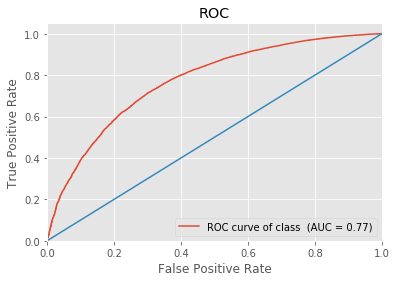

In [37]:
plotROC(y_test,y_pred)

Among all the models, we find that the result of LightGBM is best and the time for LightGBM to train and fit the data is fast. Then we check the important features in the LightGBM model and find that compared to structured features, text is less important. The most important features are the length of text, price and teacher_number_of_previously_posted_projects.   
The most important features in the model are the length of text, price and previously_posted_projects and the most useful stemmed words  are “use”, “pape”, etc.

<h3> 3.3 Build model with text(Method 2)   

In [3]:
fin = open("tfs.p", "rb");
tfs = cPickle.load(fin,encoding='latin1')
data = pd.read_csv('dat.csv',header = 0,encoding="utf-8")
fin = open("tfs-new-new-1000", "rb");
tsvd1000_newnew = cPickle.load(fin,encoding='latin1')
fin = open("tsvd100_newnew.p", "rb");
tsvd100_newnew = cPickle.load(fin,encoding='latin1')
fin = open("text100_newnew", "rb");
text100_newnew = cPickle.load(fin,encoding='latin1')
fin = open("tsvd100.p", "rb");
tsvd100 = cPickle.load(fin,encoding='latin1')
fin = open("tsvd100", "rb");
text100 = cPickle.load(fin,encoding='latin1')
# import X
fin1 = open("X.p", "rb");
X = cPickle.load(fin1,encoding='latin1')

1.Fitting without text info. for getting a taste of the outputs   
2.Fitting with text info. from tsvd100      
  Fitting with text info. from tsvd100_newnew   
  Fitting with text info. from tsvd1000_newnew  
  
3.tf-idf result analysis

In [4]:
# split the data into training & testing for the three types.

text_100 = pd.DataFrame(text100)
text_100_newnew = pd.DataFrame(text100_newnew)
text_1000_newnew = pd.DataFrame(tsvd1000_newnew)
# with tsvd100
X_new = pd.concat([X, text_100], axis=1)
from sklearn.model_selection import train_test_split
X_train_100, X_test_100, y_train, y_test = train_test_split(X_new, data[['project_is_approved']], 
                                                            test_size=0.33, random_state=42)
# with tsvd100_newnew
X_new100 = pd.concat([X, text_100_newnew], axis=1)
from sklearn.model_selection import train_test_split
X_train_100_newnew, X_test_100_newnew, y_train, y_test = train_test_split(X_new100, data[['project_is_approved']], 
                                                                          test_size=0.33, random_state=42)

# with tsvd1000_newnew
X_new50K = pd.concat([X, text_1000_newnew], axis=1)
from sklearn.model_selection import train_test_split
X_train_1000, X_test_1000, y_train, y_test = train_test_split(X_new50K,
                                                              data[['project_is_approved']], test_size=0.33, random_state=42)

<h3> 3.3.1 logistics   

In [7]:
from sklearn.linear_model import LogisticRegression
logit_tsvd100 = LogisticRegression(solver = "lbfgs")
logit_tsvd100.fit(X_train_100, y_train.values.reshape(121990,))
predictions = logit_tsvd100.predict(X_test_100)
pred_prob = logit_tsvd100.predict_proba(X_test_100)
from sklearn.metrics import roc_auc_score
roc_auc_score(y_test,pred_prob[:,1])

0.71748760702277437

In [8]:

logit_tsvd100new = LogisticRegression(solver = "lbfgs")
logit_tsvd100new.fit(X_train_100_newnew, y_train.values.reshape(121990,))
predictions = logit_tsvd100new.predict(X_test_100_newnew)
pred_prob = logit_tsvd100new.predict_proba(X_test_100_newnew)
from sklearn.metrics import roc_auc_score
roc_auc_score(y_test,pred_prob[:,1])

0.71584857337848229

In [9]:
logit_tsvd1000 = LogisticRegression(solver = "lbfgs")
logit_tsvd1000.fit(X_train_1000, y_train.values.reshape(121990,))
predictions = logit_tsvd1000.predict(X_test_1000)
pred_prob = logit_tsvd1000.predict_proba(X_test_1000)
from sklearn.metrics import roc_auc_score
roc_auc_score(y_test,pred_prob[:,1])

0.72278117730732228

<h3> 3.3.2 KNN   

For three types of text information, we try k = 20, 70, 100. It turns out that the AUC are all around 0.64. The details are in the report.

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
neighbors = [20,70,100,140]
for i in neighbors:
    knn150 = KNeighborsClassifier(n_neighbors=i)
    knn150.fit(X_train_100, y_train.values.reshape(y_train.shape[0],)) 
    pred_new150 = knn150.predict(X_test_100)
    pred_prob = knn150.predict_proba(X_test_100)

    acc = accuracy_score(y_test, pred_new150)
    print(acc)
    print(roc_auc_score(y_test,pred_prob[:,1]))

In [13]:
from sklearn.neighbors import KNeighborsClassifier
knn150 = KNeighborsClassifier(n_neighbors=140)
knn150.fit(X_train_100, y_train.values.reshape(y_train.shape[0],)) 
pred_new150 = knn150.predict(X_test_100)
pred_prob = knn150.predict_proba(X_test_100)
acc = accuracy_score(y_test, pred_new150)
print(acc)
print(roc_auc_score(y_test,pred_prob[:,1]))
from sklearn.metrics import accuracy_score
acc = accuracy_score(y_test, pred_new150)
print(acc)
print(roc_auc_score(y_test,pred_prob[:,1]))

0.848517125454
0.640924940394


<h3> 3.3.3 Random Forest   

NOTE: the text100 has achieved 0.73 AUC with maximum depth being 7.

In [18]:
## the parameters are used for comparison
max_depth = range(5,14)
for x in max_depth:
    rdf100 = RandomForestClassifier(max_depth=x, random_state=0)
    rdf100.fit(X_train_100, y_train.values.reshape(y_train.shape[0],))
    pred_prob = rdf1000.predict_proba(X_test_100)
    from sklearn.metrics import roc_auc_score
    print(roc_auc_score(y_test,pred_prob[:,1]))

0.72892848224
0.72892848224
0.72892848224
0.72892848224
0.72892848224
0.72892848224
0.72892848224
0.72892848224
0.72892848224


In [27]:
rdf100 = RandomForestClassifier(max_depth=7, random_state=0)
rdf100.fit(X_train_100, y_train.values.reshape(y_train.shape[0],))
pred_prob = rdf100.predict_proba(X_test_100)
from sklearn.metrics import roc_auc_score
roc_auc_score(y_test,pred_prob[:,1])

0.72953815601987393

Another great quality of random forest is that they make it very easy to measure the relative importance of each feature. Sklearn measure a features importance by looking at how much the tree nodes, that use that feature, reduce impurity on average (across all trees in the forest). It computes this score automatically for each feature after training and scales the results so that the sum of all importances is equal to 1. 

In [29]:
importances = pd.DataFrame({'feature':X_train_100.columns,'importance':np.round(rdf100.feature_importances_,3)})
importances = importances.sort_values('importance',ascending=False).set_index('feature')
importances.head(5)

,importance
feature,
count_items,0.244
quantity,0.056
e2_len,0.049
price,0.043
19,0.043


In [31]:
max_depth = range(3,14)
for i in max_depth:
    rdf1000 = RandomForestClassifier( max_depth=i, random_state=0)
    rdf1000.fit(X_train_1000, y_train.values.reshape(y_train.shape[0],))
    pred_prob = rdf1000.predict_proba(X_test_1000)
    print("max depth: "+ str(i) + ": " + str(roc_auc_score(y_test,pred_prob[:,1])))

max depth: 3: 0.679634446908
max depth: 4: 0.692581026062
max depth: 5: 0.697528166449
max depth: 6: 0.695953418099
max depth: 7: 0.703711403439
max depth: 8: 0.704740642628
max depth: 9: 0.705077660953
max depth: 10: 0.699052704304
max depth: 11: 0.688613411076
max depth: 12: 0.686873596571
max depth: 13: 0.690034409785


In [34]:
rdf1000 = RandomForestClassifier( max_depth=9, random_state=0)
rdf1000.fit(X_train_1000, y_train.values.reshape(y_train.shape[0],))
pred_prob = rdf1000.predict_proba(X_test_1000)
from sklearn.metrics import roc_auc_score
roc_auc_score(y_test,pred_prob[:,1])
importances = pd.DataFrame({'feature':X_train_1000.columns,'importance':np.round(rdf1000.feature_importances_,3)})
importances = importances.sort_values('importance',ascending=False).set_index('feature')
importances.head(5)

,importance
feature,
count_items,0.101
price,0.055
quantity,0.050
2,0.039
1,0.036


<h3> 4.1 TF-IDF Result Analysis

In [35]:
cachedStopWords = stopwords.words("english")

stemmer = PorterStemmer().stem
tokenize = nltk.word_tokenize

def stem(tokens,stemmer = PorterStemmer().stem):
     return [stemmer(w.lower()) for w in tokens] 

def lemmatize(text):
     return stem(tokenize(text))

def testFuncNew(text):
    tokens = word_tokenize(str(text))
    textnew = [w for w in tokens if w not in cachedStopWords]
    #textnew = ' '.join([word for word in text.split() if word not in cachedStopWords])
    #textnew = [word for word in text.split() if word not in cachedStopWords]
    return(textnew)

Define functions that take a single row of the tf-idf matrix (corresponding to a particular document), and return the n highest scoring words (or more generally tokens or features)

In [36]:
def top_tfidf_feats(row, features, top_n=25, names = "tfidf"):
    ''' Get top n tfidf values in row and return them with their corresponding feature names.'''
    topn_ids = np.argsort(row)[::-1][:top_n]
    top_feats = [(features[i], row[i]) for i in topn_ids]
    df = pd.DataFrame(top_feats)
    df.columns = ['feature', str(names)]
    return df
def top_feats_in_doc(Xtr, features, row_id, top_n=25,names = "tfidf"):
# Top tfidf features in specific document (matrix row) '''
    row = np.squeeze(Xtr[row_id].toarray())
    return top_tfidf_feats(row, features, top_n,names = names)

Check if this topic is represented also in the overall corpus. For this, we will calculate the average tf-idf score of all words across a number of documents (in this case all documents), i.e. the average per column of a tf-idf matrix:

In [37]:
def top_mean_feats(Xtr, features, grp_ids=None, min_tfidf=0.1, top_n=25, names="default"):
    ''' Return the top n features that on average are most important amongst documents in rows
        indentified by indices in grp_ids. '''
    if grp_ids:
        D = Xtr[grp_ids].toarray()
    else:
        D = Xtr.toarray()

    D[D < min_tfidf] = 0
    tfidf_means = np.mean(D, axis=0)
    return top_tfidf_feats(tfidf_means, features, top_n, names)


In [38]:
fin = open("new-tfs-vec-10000.p", "rb");
new_tfs_vec_10000 = cPickle.load(fin,encoding='latin1')
new_tfs_vec_10000
fin = open("new-tfs-10000.p", "rb");
new_tfs_10000 = cPickle.load(fin,encoding='latin1')
new_tfs_10000
features_new_10000 = new_tfs_vec_10000.get_feature_names()

In [39]:
top_feats_in_doc(new_tfs_10000, features_new_10000, 1, top_n = 10, names = "new10000")

,feature,new10000
0,,310.000000
1,da,14.902434
2,ce,10.511561
3,populatio,9.828842
4,580,9.556837
5,club,9.377287
6,ls,9.284167
7,g,9.000741
8,fo,8.343846
9,eog,8.030781


In [40]:
top_mean_feats(new_tfs_10000[1:5000,:], features_new_10000,min_tfidf=0.1, top_n = 15, names = "new10000")

,feature,new10000
0,,406.954191
1,g,15.241704
2,e,13.770888
3,ts,9.232046
4,stude,8.875775
5,ou,4.077087
6,fo,4.054460
7,lea,3.992491
8,thei,3.914428
9,p,3.902561


In [41]:
def top_feats_by_class(Xtr, y, features, grid = None, min_tfidf=0.1, top_n=25, names = "default"):
    ''' Return a list of dfs, where each df holds top_n features and their mean tfidf value
        calculated across documents with the same class label. '''
    dfs = []
    labels = np.unique(y)
    for label in labels:
        ids = np.where(y==label)
        #top_mean_feats(Xtr, features, grp_ids=None, min_tfidf=0.1, top_n=25, names="default")
        feats_df = top_mean_feats(Xtr, features, grid, min_tfidf=min_tfidf, top_n=top_n, names = names)
        feats_df.label = label
        dfs.append(feats_df)
    return dfs

In [42]:
dfs = top_feats_by_class(new_tfs_10000[1:5000,:], data[['project_is_approved']].iloc[1:5000,:], features_new_10000,
                   top_n=15, names = "new10000")

In [43]:
def plot_tfidf_classfeats_h(dfs):
    ''' Plot the data frames returned by the function plot_tfidf_classfeats(). '''
    fig = plt.figure(figsize=(12, 9), facecolor="w")
    x = np.arange(len(dfs[0]))
    for i, df in enumerate(dfs):
        ax = fig.add_subplot(1, len(dfs), i+1)
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)
        ax.set_frame_on(False)
        ax.get_xaxis().tick_bottom()
        ax.get_yaxis().tick_left()
        ax.set_xlabel("Mean Tf-Idf Score", labelpad=16, fontsize=14)
        ax.set_title("label = " + str(df.label), fontsize=16)
        ax.ticklabel_format(axis='x', style='sci', scilimits=(-2,2))
        ax.barh(x, df.new10000, align='center', color='#3F5D7D')
        ax.set_yticks(x)
        ax.set_ylim([-1, x[-1]+1])
        yticks = ax.set_yticklabels(df.feature)
        plt.subplots_adjust(bottom=0.09, right=0.97, left=0.15, top=0.95, wspace=0.52)
    plt.show()

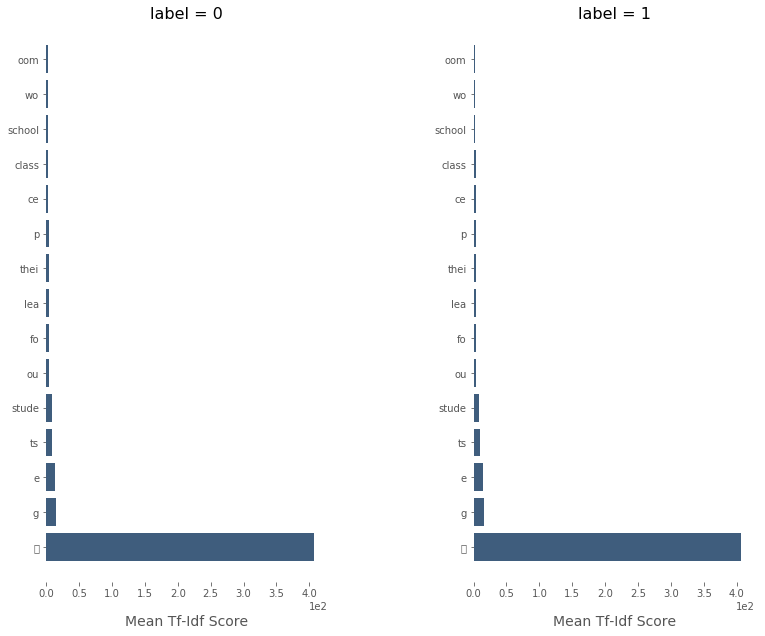

In [44]:
plot_tfidf_classfeats_h(dfs)

In [45]:
print(dfs[0])

   feature    new10000
0          406.954191
1        g   15.241704
2        e   13.770888
3       ts    9.232046
4    stude    8.875775
5       ou    4.077087
6       fo    4.054460
7      lea    3.992491
8     thei    3.914428
9        p    3.902561
10      ce    3.231199
11   class    3.105403
12  school    2.789710
13      wo    2.660504
14     oom    2.619654


In [46]:
print(dfs[1])

   feature    new10000
0          406.954191
1        g   15.241704
2        e   13.770888
3       ts    9.232046
4    stude    8.875775
5       ou    4.077087
6       fo    4.054460
7      lea    3.992491
8     thei    3.914428
9        p    3.902561
10      ce    3.231199
11   class    3.105403
12  school    2.789710
13      wo    2.660504
14     oom    2.619654
